In [1]:
%load_ext iminizinc
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import datetime
from z3 import *

<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.4.3, build 122680178
Copyright (C) 2014-2020 Monash University, NICTA, Data61


<b> <h2> ACCESSORY FUNCTIONS </h2> </b>

In [33]:
"""
Read a given instance of the Present Wrapping Problem(PWP)
Format:
1-9 12  width and height of the paper roll(strip)
2-5     the number of necessary pieces of paper to cut off
3-3 3   n lines follow, each with xi and yi, representing the horizontal and vertical dimensions of the i-th piece of paper
4-2 4
5-2 8
6-3 9
7-4 12
"""
def read_instance(path):
    file = open(path,"r").readlines()
    pr_w , pr_h = tuple(map(int, file[0].rstrip("\n").split(" ")))
    n_pieces = int(file[1].rstrip("\n"))
    L = []
    for i in range(2, n_pieces + 2):
        L.append(list(map(int, file[i].rstrip("\n").split(" "))))
    return pr_w, pr_h, n_pieces, L


"""
Save given solution/s for a specific instance of the Present Wrapping Problem(PWP)

File name Format: width x height [(# solution)][-rot].txt
    just 1 solution => no (# sol.)   
    -rot only if pieces rotation enabled

Content Format:
1-9 12       width and height of the paper roll(strip)
2-5          the number of pieces
3-3 3   4 0  n lines follow, each with xi, yi and the corresponding solution coordinates(x y)
4-2 4   7 0  
5-2 8   7 4  
6-3 9   4 3  
7-4 12  0 0  
"""
def save_solution(path, pr_w, pr_h, n_pieces, pieces, solutions):
    MAX_SAVING_SOL = 10   #given n solution I will create(save) at most MAX_SAVING_SOL files.(I want to avoid creating thousands of files)
    
    # Only one solution
    if not isinstance(solutions, list):
        solutions = [solutions]
        
    for n, sol in enumerate(solutions):
        print(n)
        dim = []
        rot = "-rot" if 'rot' in sol else ""
        name = f"{path}/{pr_w}x{pr_h}{rot}.txt" if n==0 else f"{path}/{pr_w}x{pr_h}({n}){rot}.txt"
        q = sol["q"]
        
        f = open(name, "w")
        f.write(f"{pr_w} {pr_h}\n")
        f.write(f"{n_pieces}\n")
        dim = pieces
        if 'rot' in sol: #Managed the save with rotation   0:no rotation, 1:yes rotation
            dim = update_dim_based_on_rot(dim, sol["rot"])
            
        for i, p in enumerate(dim):
            f.write(f"{p[0]} {p[1]}\t{q[i][0]} {q[i][1]}\n")
        
        f.close()
        
        if n>=MAX_SAVING_SOL:
            break

In [3]:
"""
Given the pieces make the ascending or descending ordering according to the 'reverse' boolean value
"""
def order_pieces(pieces, reverse=False):
    areas = [p[0] * p[1] for p in pieces]
    sorted_indices = sorted(range(len(areas)), key=lambda k: areas[k], reverse=reverse)
    ordered_pieces = [pieces[i] for i in sorted_indices]
    return ordered_pieces

In [4]:
PRINT_FIRST_N_SOL = 100
PRINT_LAST_N_SOL = 100
PRINT_EVERY_N_SOL = 10000

"""
Given an instance and 1 solution, create a graphical representation of that solution
"""
def graph_solution(pr_w, pr_h, n_pieces, pieces, q, colours=None):
    if colours is None:
        colours = np.random.rand(n_pieces, 3)
    fig, ax = plt.subplots()
    for i in range(n_pieces):
        ax.add_patch(patches.Rectangle(
            q[i],
            pieces[i][0],
            pieces[i][1],
            facecolor=colours[i]
        ))
    ax.axis("equal")
    ax.xaxis.set_ticks(np.arange(0, pr_w+2, 2))
    ax.set_xlim(0, pr_w)
    ax.yaxis.set_ticks(np.arange(0, pr_h+2, 2))
    ax.set_ylim(0, pr_h)
    plt.show()
    print(f"Solution: {q}")
    print(f"[w, h]:   {pieces}\n")

"""
Given the dimensions of each pieces(width and height), according to the rotation information, 
the function modify the width and height for each of them.
ex: 
l  = [[5, 5], [5, 3], [3, 5], [3, 3]]
rot= [0, 1, 1, 0]

c  = [[5, 5], [3, 5], [5, 3], [3, 3]] returned
"""
def update_dim_based_on_rot(l, rot):
    c = []
    for i, r in enumerate(rot):
        if r == 1: #I have to invert the i-th value of l
            c.append([l[i][1], l[i][0]])
        else:
            c.append([l[i][0], l[i][1]])
    return c
    
"""
Print the first PRINT_FIRST_N_SOL, the last PRINT_LAST_N_SOL solutions and in between every PRINT_EVERY_N_SOL solutions.
"""
def print_solutions(res, instance_info):
    n_sol = len(res)
    colours = np.random.rand(instance_info['n'], 3)
    if not isinstance(res, list):
        n_sol = 1
        print("coords:   {}".format(res["q"]))
        dim = instance_info['p']
        if 'rot' in res: #I manage the printing with rotation   0:no rotation, 1:yes rotation
            print("rotation: {}".format(res["rot"]))
            dim = update_dim_based_on_rot(dim, res["rot"])
            
        graph_solution(instance_info['w'], instance_info['h'], instance_info['n'], dim, res["q"], colours)
    else:
        last_i = 0
        for i, x in enumerate(res):
            dim = []
            if i < PRINT_FIRST_N_SOL or i >= (n_sol-PRINT_LAST_N_SOL) or ((i+1)%PRINT_EVERY_N_SOL == 0):
                if i > last_i+1:
                    print(" ... ")
                print("{} : {} ".format(i, x['q']))
                
                dim = instance_info['p']
                if 'rot' in x: #I manage the printing with rotation   0:no rotation, 1:yes rotation
                    print("rotation: {}".format(x["rot"]))
                    dim = update_dim_based_on_rot(dim, x["rot"])
                
                graph_solution(instance_info['w'], instance_info['h'], instance_info['n'], dim, x["q"], colours)
                last_i = i
                
    print("Tot: {}\n".format(n_sol))

<b> <h2> INPUT </h2> </b>

<b> TEST 1 </b> (see report) <br>
Open the mzn model(pwp_v8.mzn), set 'bool: independent_solving_on_w <b>= false</b>;'(line 22) and comment the search_ann lines at the end of the model(from line 77 to 82). Comment first also the "<b>Symmetry breaking rules</b>" part(from line 52 to 54) and later uncomment it.<br>
Set 'ord_type' as described below and run the next cell three times <br>
no-ord $\;\;$  => set ord_type = 'no-ord' <br>
ord $\;\;\;\;\;\;$     => set ord_type = 'ord' <br>
decr-ord => set ord_type = 'decr-ord'

In [5]:
model_name = "pwp_v8.mzn"
instances_name = ["8x8","9x9","10x10","11x11","12x12","13x13","14x14","15x15","16x16","17x17","18x18","19x19","20x20","21x21"]

In [6]:
"""
Run this part 3 times changing the 'ord_type' value with the "Symmetry breaking rules" part commented and uncommented.
"""

ord_type = 'no-ord'#-1°   'ord'-2°   'decr-ord'-3°
for i in instances_name:
    path = f"CP/Instances/{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    if ord_type in ['ord','decr-ord']:
        unordered_pieces = list(L)
        decr_order = True if ord_type == 'decr-ord' else False
        L = order_pieces(L, reverse=decr_order)
    
    print(f"|| === Instance {i} === ||")
    solutions = %minizinc -a -s CP/$model_name -t 300000
    #print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

|| === Instance 8x8 === ||
Warning, ignored search annotation: search_ann
%%%mzn-stat: nSolutions=3
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=24
mzn-stat: flatIntVars=18
mzn-stat: flatBoolConstraints=6
mzn-stat: flatIntConstraints=36
mzn-stat: evaluatedHalfReifiedConstraints=24
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.163389
mzn-stat-end
mzn-stat: initTime=0.008
mzn-stat: solveTime=0
mzn-stat: solutions=3
mzn-stat: variables=42
mzn-stat: propagators=22
mzn-stat: propagations=162
mzn-stat: nodes=7
mzn-stat: failures=1
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end
|| === Instance 9x9 === ||
Warning, ignored search annotation: search_ann
%%%mzn-stat: nSolutions=16
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=40
mzn-stat: flatIntVars=21
mzn-stat: flatBoolConstraints=10
mzn-stat: flatIntConstraints=53
mzn-stat: evaluatedHalfReifiedConstraints=40
mzn-stat: method="satisfy"
mzn-stat: flatTi

Warning, ignored search annotation: search_ann
%%%mzn-stat: nSolutions=478656
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=420
mzn-stat: flatIntVars=62
mzn-stat: flatBoolConstraints=105
mzn-stat: flatIntConstraints=454
mzn-stat: evaluatedHalfReifiedConstraints=420
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.241422
mzn-stat-end
mzn-stat: initTime=0.029
mzn-stat: solveTime=156.17
mzn-stat: solutions=478656
mzn-stat: variables=482
mzn-stat: propagators=507
mzn-stat: propagations=471378184
mzn-stat: nodes=5395049
mzn-stat: failures=2218869
mzn-stat: restarts=0
mzn-stat: peakDepth=44
mzn-stat-end


<b> TEST 2 </b> (see report) <br>
Open the mzn model(pwp_v8.mzn), set 'bool: independent_solving_on_w <b>= false</b>;'(line 22) <br>
Comment and uncomment by hands from the first search_ann line to the last (from line 77 to 82) to execute the test two times, 'ord_type<b>=ord|decr-ord</b>'.<br>
ord $\;\;\;\;\;\;$     => decr_order = <u>False</u> and apply ordering <br>
decr-ord => decr_order = <u>True</u> and apply ordering <br>
NB: comment/uncomment the relative search_ann row inside the model(pwp_v8.mzn)

In [18]:
"""
Run this part 2(ord_type=ord|decr-ord) times for each search_ann possible(I-min, ff-min, DomWdeg-min, I-rand, ff-rand, DomWdeg-rand).
"""
ord_type = 'ord'#-1°   'decr-ord'-2°
for i in instances_name:
    path = f"CP/Instances/{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    if ord_type in ['ord','decr-ord']:
        unordered_pieces = list(L)
        decr_order = True if ord_type == 'decr-ord' else False
        L = order_pieces(L, reverse=decr_order)
    
    print(f"|| === Instance {i} === ||")
    solutions = %minizinc -a -s CP/$model_name -t 300000
    #print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

|| === Instance 8x8 === ||
%%%mzn-stat: nSolutions=3
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=24
mzn-stat: flatIntVars=18
mzn-stat: flatBoolConstraints=6
mzn-stat: flatIntConstraints=36
mzn-stat: evaluatedHalfReifiedConstraints=24
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.163908
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0.001
mzn-stat: solutions=3
mzn-stat: variables=42
mzn-stat: propagators=22
mzn-stat: propagations=170
mzn-stat: nodes=9
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end
|| === Instance 9x9 === ||
%%%mzn-stat: nSolutions=16
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=40
mzn-stat: flatIntVars=20
mzn-stat: flatBoolConstraints=10
mzn-stat: flatIntConstraints=53
mzn-stat: evaluatedHalfReifiedConstraints=40
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.175376
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0.001
mzn-stat: solut

<b> TEST 3 </b> (see report) <br>
Open the mzn model(pwp_v8.mzn), set 'bool: independent_solving_on_w <b>= independent_solving_on_w_possible()</b>;'(line 22) <br>
Uncomment the line corresponding the best search_ann strategy(line 79) inside the model(pwp_v8.mzn)

|| === Instance 8x8 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=4
mzn-stat: flatIntVars=13
mzn-stat: flatBoolConstraints=2
mzn-stat: flatIntConstraints=12
mzn-stat: evaluatedHalfReifiedConstraints=4
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.161429
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=34
mzn-stat: propagators=12
mzn-stat: propagations=34
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end


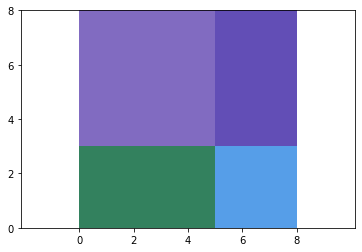

Solution: [[5, 0], [5, 3], [0, 0], [0, 3]]
[w, h]:   [[3, 3], [3, 5], [5, 3], [5, 5]]

Pieces: [[3, 3], [3, 5], [5, 3], [5, 5]]



|| === Instance 9x9 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=40
mzn-stat: flatIntVars=20
mzn-stat: flatBoolConstraints=10
mzn-stat: flatIntConstraints=53
mzn-stat: evaluatedHalfReifiedConstraints=40
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.172001
mzn-stat-end
mzn-stat: initTime=0.013
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=64
mzn-stat: propagators=51
mzn-stat: propagations=138
mzn-stat: nodes=5
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=4
mzn-stat-end


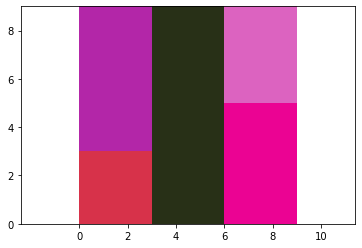

Solution: [[0, 0], [6, 5], [6, 0], [0, 3], [3, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]



|| === Instance 10x10 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=58
mzn-stat: flatIntVars=23
mzn-stat: flatBoolConstraints=15
mzn-stat: flatIntConstraints=72
mzn-stat: evaluatedHalfReifiedConstraints=58
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.160519
mzn-stat-end
mzn-stat: initTime=0.013
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=90
mzn-stat: propagators=58
mzn-stat: propagations=217
mzn-stat: nodes=9
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end


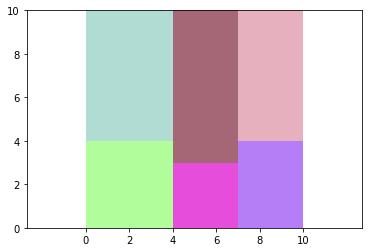

Solution: [[4, 0], [7, 0], [7, 4], [4, 3], [0, 0], [0, 4]]
[w, h]:   [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]

Pieces: [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]



|| === Instance 11x11 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=84
mzn-stat: flatIntVars=30
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=102
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.161008
mzn-stat-end
mzn-stat: initTime=0.014
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=114
mzn-stat: propagators=107
mzn-stat: propagations=2261
mzn-stat: nodes=44
mzn-stat: failures=17
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


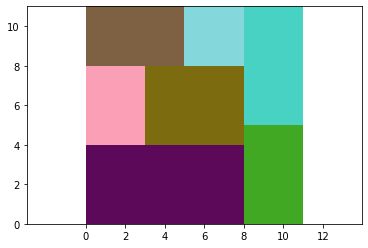

Solution: [[5, 8], [0, 4], [8, 0], [8, 5], [0, 8], [3, 4], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]



|| === Instance 12x12 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=112
mzn-stat: flatIntVars=34
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=132
mzn-stat: evaluatedHalfReifiedConstraints=112
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.174809
mzn-stat-end
mzn-stat: initTime=0.016
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=146
mzn-stat: propagators=139
mzn-stat: propagations=2778
mzn-stat: nodes=56
mzn-stat: failures=24
mzn-stat: restarts=0
mzn-stat: peakDepth=10
mzn-stat-end


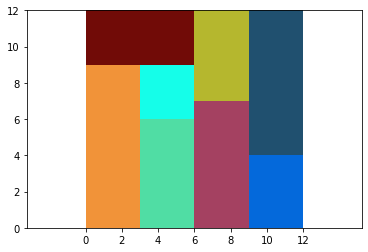

Solution: [[3, 6], [9, 0], [6, 7], [3, 0], [6, 0], [9, 4], [0, 0], [0, 9]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]



|| === Instance 13x13 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=144
mzn-stat: flatIntVars=38
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=166
mzn-stat: evaluatedHalfReifiedConstraints=144
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.173278
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.002
mzn-stat: solutions=1
mzn-stat: variables=182
mzn-stat: propagators=189
mzn-stat: propagations=15110
mzn-stat: nodes=240
mzn-stat: failures=114
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end


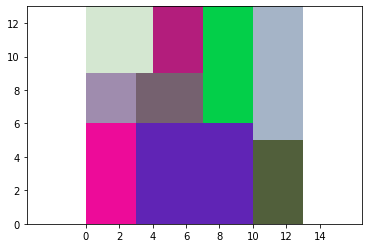

Solution: [[0, 6], [4, 9], [10, 0], [0, 0], [7, 6], [10, 5], [3, 6], [0, 9], [3, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]



|| === Instance 14x14 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=142
mzn-stat: flatIntVars=35
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=162
mzn-stat: evaluatedHalfReifiedConstraints=142
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.166735
mzn-stat-end
mzn-stat: initTime=0.014
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=186
mzn-stat: propagators=147
mzn-stat: propagations=965
mzn-stat: nodes=24
mzn-stat: failures=8
mzn-stat: restarts=0
mzn-stat: peakDepth=7
mzn-stat-end


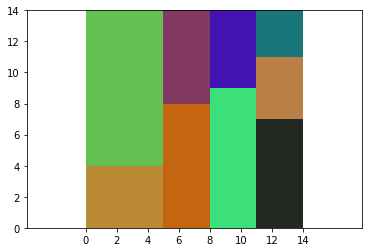

Solution: [[11, 11], [11, 7], [8, 9], [5, 8], [11, 0], [5, 0], [8, 0], [0, 0], [0, 4]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]



|| === Instance 15x15 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=180
mzn-stat: flatIntVars=40
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=203
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.170451
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=224
mzn-stat: propagators=214
mzn-stat: propagations=1705
mzn-stat: nodes=19
mzn-stat: failures=4
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end


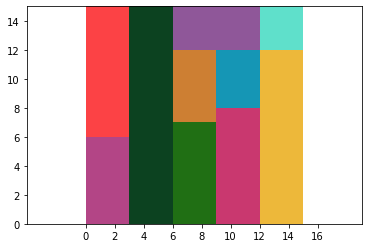

Solution: [[12, 12], [9, 8], [6, 7], [0, 0], [6, 0], [9, 0], [0, 6], [12, 0], [3, 0], [6, 12]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]



|| === Instance 16x16 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=180
mzn-stat: flatIntVars=42
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=204
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.165248
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=222
mzn-stat: propagators=220
mzn-stat: propagations=3974
mzn-stat: nodes=52
mzn-stat: failures=21
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end


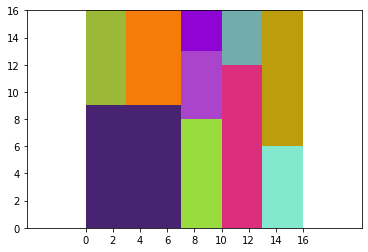

Solution: [[7, 13], [10, 12], [7, 8], [13, 0], [0, 9], [7, 0], [13, 6], [10, 0], [3, 9], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]



|| === Instance 17x17 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=264
mzn-stat: flatIntVars=50
mzn-stat: flatBoolConstraints=66
mzn-stat: flatIntConstraints=292
mzn-stat: evaluatedHalfReifiedConstraints=264
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.167489
mzn-stat-end
mzn-stat: initTime=0.016
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=314
mzn-stat: propagators=335
mzn-stat: propagations=3128
mzn-stat: nodes=46
mzn-stat: failures=15
mzn-stat: restarts=0
mzn-stat: peakDepth=19
mzn-stat-end


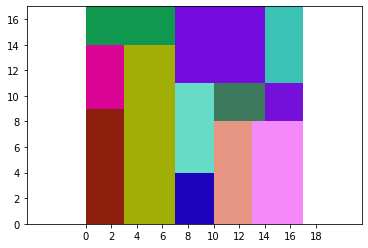

Solution: [[14, 8], [7, 0], [0, 9], [14, 11], [7, 4], [10, 0], [0, 0], [10, 8], [13, 0], [3, 0], [0, 14], [7, 11]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]



|| === Instance 18x18 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=392
mzn-stat: flatIntVars=57
mzn-stat: flatBoolConstraints=104
mzn-stat: flatIntConstraints=420
mzn-stat: evaluatedHalfReifiedConstraints=392
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.178349
mzn-stat-end
mzn-stat: initTime=0.019
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=482
mzn-stat: propagators=392
mzn-stat: propagations=1790
mzn-stat: nodes=29
mzn-stat: failures=5
mzn-stat: restarts=0
mzn-stat: peakDepth=19
mzn-stat-end


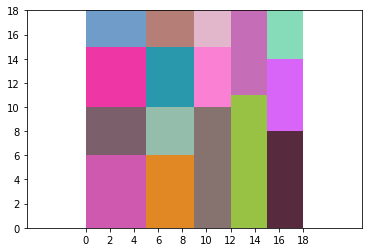

Solution: [[9, 15], [15, 14], [9, 10], [15, 8], [12, 11], [15, 0], [9, 0], [12, 0], [5, 15], [5, 6], [5, 10], [5, 0], [0, 15], [0, 6], [0, 10], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]



|| === Instance 19x19 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=358
mzn-stat: flatIntVars=52
mzn-stat: flatBoolConstraints=91
mzn-stat: flatIntConstraints=386
mzn-stat: evaluatedHalfReifiedConstraints=358
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.178842
mzn-stat-end
mzn-stat: initTime=0.018
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=427
mzn-stat: propagators=365
mzn-stat: propagations=2943
mzn-stat: nodes=40
mzn-stat: failures=12
mzn-stat: restarts=0


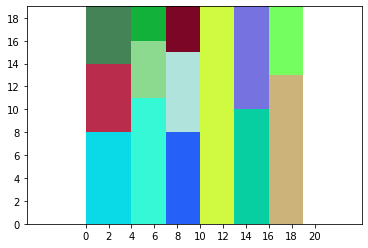

Solution: [[4, 16], [7, 15], [4, 11], [16, 13], [7, 8], [7, 0], [13, 10], [13, 0], [4, 0], [16, 0], [10, 0], [0, 14], [0, 8], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]



|| === Instance 20x20 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=364
mzn-stat: flatIntVars=58
mzn-stat: flatBoolConstraints=91
mzn-stat: flatIntConstraints=396
mzn-stat: evaluatedHalfReifiedConstraints=364
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.174053
mzn-stat-end
mzn-stat: initTime=0.02
mzn-stat: solveTime=0.009
mzn-stat: solutions=1
mzn-stat: variables=422
mzn-stat: propagators=346
mzn-stat: propagations=46943
mzn-stat: nodes=769
mzn-stat: failures=376
mzn-stat: restarts=0
mzn-stat: peakDepth=21
mzn-stat-end


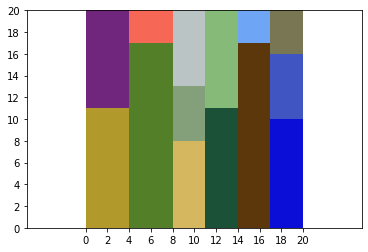

Solution: [[14, 17], [17, 16], [8, 8], [17, 10], [8, 13], [8, 0], [11, 11], [17, 0], [11, 0], [14, 0], [4, 17], [0, 11], [0, 0], [4, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]



|| === Instance 21x21 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=388
mzn-stat: flatIntVars=56
mzn-stat: flatBoolConstraints=99
mzn-stat: flatIntConstraints=417
mzn-stat: evaluatedHalfReifiedConstraints=388
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.187268
mzn-stat-end
mzn-stat: initTime=0.02
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=465
mzn-stat: propagators=361
mzn-stat: propagations=2361
mzn-stat: nodes=37
mzn-stat: failures=10
mzn-stat: restarts=0
mzn-stat: peakDepth=21
mzn-stat-end


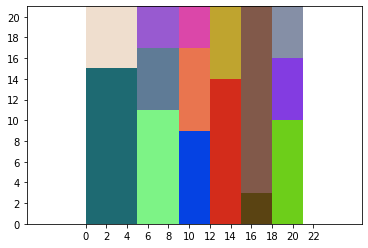

Solution: [[15, 0], [9, 17], [18, 16], [18, 10], [12, 14], [9, 9], [9, 0], [18, 0], [12, 0], [15, 3], [5, 17], [5, 11], [5, 0], [0, 15], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]



|| === Instance 22x22 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=480
mzn-stat: flatIntVars=64
mzn-stat: flatBoolConstraints=120
mzn-stat: flatIntConstraints=515
mzn-stat: evaluatedHalfReifiedConstraints=480
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.1977
mzn-stat-end
mzn-stat: initTime=0.023
mzn-stat: solveTime=3.266
mzn-stat: solutions=1
mzn-stat: variables=548
mzn-stat: propagators=561
mzn-stat: propagations=20034185
mzn-stat: nodes=197099
mzn-stat: failures=98539
mzn-stat: restarts=0
mzn-sta

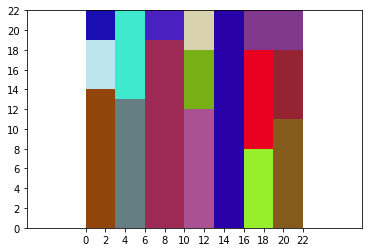

Solution: [[0, 19], [10, 18], [0, 14], [10, 12], [19, 11], [16, 0], [3, 13], [16, 8], [19, 0], [10, 0], [3, 0], [0, 0], [13, 0], [6, 19], [6, 0], [16, 18]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]



|| === Instance 23x23 === ||
%%%mzn-stat: nSolutions=0
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=78
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=726
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.195262
mzn-stat-end
No solution has been found
mzn-stat: initTime=0.029
mzn-stat: solveTime=299.806
mzn-stat: solutions=0
mzn-stat: variables=762
mzn-stat: propagators=850
mzn-stat: propagations=904730509
mzn-stat: nod

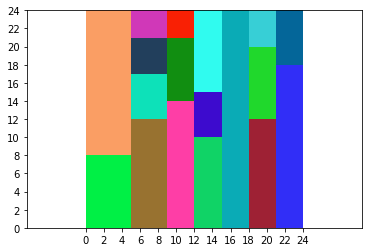

Solution: [[9, 21], [18, 20], [12, 10], [21, 18], [9, 14], [18, 12], [12, 15], [12, 0], [18, 0], [9, 0], [21, 0], [15, 0], [5, 21], [5, 17], [5, 12], [5, 0], [0, 0], [0, 8]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]



|| === Instance 25x25 === ||
%%%mzn-stat: nSolutions=0
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=76
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=725
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.242337
mzn-stat-end
No solution has been found
mzn-stat: initTime=0.037
mzn-stat: solveTime=299.759
mzn-stat: solutions=0
mzn-stat: variables=764
mzn-stat: propagators=

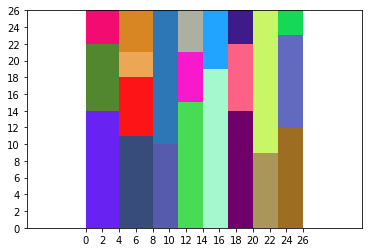

Solution: [[23, 23], [17, 22], [11, 21], [11, 15], [14, 19], [17, 14], [20, 0], [8, 0], [23, 12], [23, 0], [17, 0], [11, 0], [8, 10], [20, 9], [14, 0], [4, 18], [0, 22], [4, 21], [4, 11], [0, 14], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]



|| === Instance 27x27 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=840
mzn-stat: flatIntVars=86
mzn-stat: flatBoolConstraints=210
mzn-stat: flatIntConstraints=886
mzn-stat: evaluatedHalfReifiedConstraints=840
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.251634
mzn-stat-end
mzn-stat: initTime=0.043
mzn-stat: solv

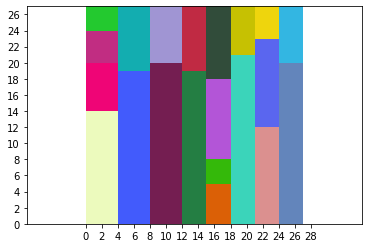

Solution: [[15, 5], [21, 23], [15, 0], [18, 21], [24, 20], [12, 19], [15, 18], [15, 8], [21, 12], [21, 0], [12, 0], [24, 0], [18, 0], [0, 24], [0, 20], [0, 14], [8, 20], [4, 19], [0, 0], [4, 0], [8, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]



|| === Instance 28x28 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=918
mzn-stat: flatIntVars=86
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=963
mzn-stat: evaluatedHalfReifiedConstraints=918
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.257717
mzn-stat-end
mzn-stat: initTime=0.046
mzn-stat: solveTime=0.06
mzn-stat: solutio

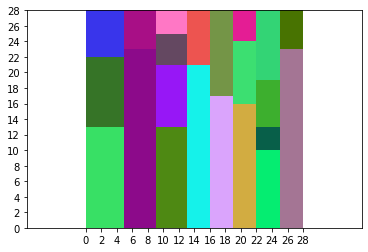

Solution: [[22, 10], [19, 24], [25, 23], [22, 13], [13, 21], [19, 16], [22, 19], [22, 0], [16, 17], [19, 0], [16, 0], [13, 0], [25, 0], [9, 25], [9, 21], [5, 23], [9, 13], [9, 0], [5, 0], [0, 22], [0, 13], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]



|| === Instance 29x29 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1098
mzn-stat: flatIntVars=94
mzn-stat: flatBoolConstraints=276
mzn-stat: flatIntConstraints=1147
mzn-stat: evaluatedHalfReifiedConstraints=1098
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.268588
mzn-stat-end
mzn-stat: initTime=0.055
mzn-stat: so

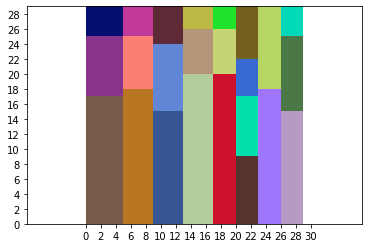

Solution: [[17, 26], [26, 25], [20, 17], [17, 20], [20, 22], [20, 9], [20, 0], [26, 15], [23, 18], [26, 0], [23, 0], [17, 0], [13, 26], [5, 25], [9, 24], [13, 20], [5, 18], [9, 15], [9, 0], [5, 0], [13, 0], [0, 25], [0, 17], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]



|| === Instance 30x30 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=720
mzn-stat: flatIntVars=73
mzn-stat: flatBoolConstraints=185
mzn-stat: flatIntConstraints=757
mzn-stat: evaluatedHalfReifiedConstraints=720
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.251538
mz

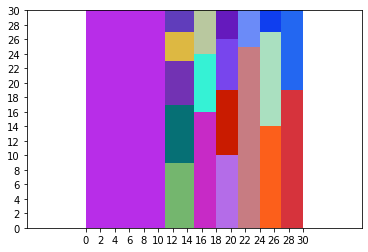

Solution: [[24, 27], [18, 26], [21, 25], [15, 24], [18, 19], [15, 16], [18, 10], [18, 0], [27, 19], [24, 14], [24, 0], [15, 0], [27, 0], [21, 0], [11, 27], [11, 23], [11, 17], [11, 9], [11, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]



|| === Instance 31x31 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=654
mzn-stat: flatIntVars=69
mzn-stat: flatBoolConstraints=167
mzn-stat: flatIntConstraints=689
mzn-stat: evaluatedHalfReifiedConstraints=654
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.24382
mzn-stat-end
mzn-stat: initTime=0.035
mzn-stat: solveTime=0.018
mzn-stat: solutions=1
mzn-stat: va

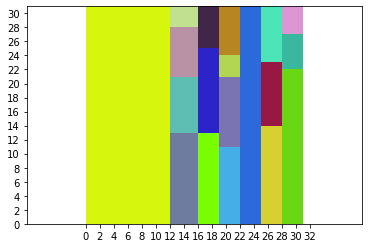

Solution: [[19, 21], [28, 27], [28, 22], [16, 25], [19, 24], [25, 23], [25, 14], [19, 11], [19, 0], [16, 13], [16, 0], [25, 0], [28, 0], [22, 0], [12, 28], [12, 21], [12, 13], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]



|| === Instance 32x32 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1404
mzn-stat: flatIntVars=110
mzn-stat: flatBoolConstraints=351
mzn-stat: flatIntConstraints=1462
mzn-stat: evaluatedHalfReifiedConstraints=1404
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.290544
mzn-stat-end
mzn-stat: initTime=0.071
mzn-stat: solveTime=16.017
mzn-stat: solutions=1
mzn-stat: variables=1514
mzn-

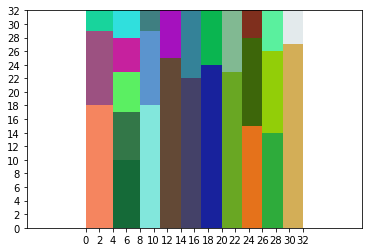

Solution: [[8, 29], [23, 28], [29, 27], [26, 26], [11, 25], [17, 24], [20, 23], [14, 22], [8, 18], [26, 14], [23, 15], [26, 0], [23, 0], [8, 0], [14, 0], [20, 0], [17, 0], [11, 0], [29, 0], [0, 29], [4, 28], [4, 23], [4, 17], [4, 10], [4, 0], [0, 18], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]



|| === Instance 33x33 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1010
mzn-stat: flatIntVars=89
mzn-stat: flatBoolConstraints=253
mzn-stat: flatIntConstraints=1057
mzn-stat: eval

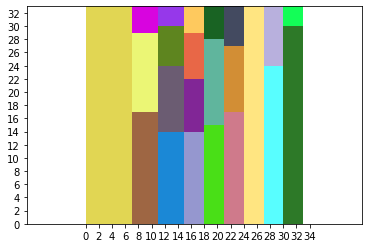

Solution: [[30, 30], [15, 29], [18, 28], [21, 27], [15, 22], [15, 14], [27, 24], [21, 17], [18, 15], [15, 0], [18, 0], [21, 0], [27, 0], [30, 0], [24, 0], [11, 30], [7, 29], [11, 24], [11, 14], [7, 17], [11, 0], [7, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]



|| === Instance 34x34 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=810
mzn-stat: flatIntVars=77
mzn-stat: flatBoolConstraints=206
mzn-stat: flatIntConstraints=849
mzn-stat: evaluatedHalfReifiedConstraints=810
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.253734
mzn-stat-end
mz

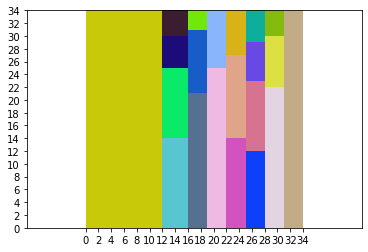

Solution: [[16, 31], [28, 30], [25, 29], [25, 23], [22, 27], [28, 22], [19, 25], [16, 21], [25, 12], [25, 0], [22, 14], [22, 0], [16, 0], [28, 0], [19, 0], [31, 0], [12, 30], [12, 25], [12, 14], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]



|| === Instance 35x35 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=924
mzn-stat: flatIntVars=86
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=970
mzn-stat: evaluatedHalfReifiedConstraints=924
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.25639
mzn-stat-end
mzn-stat: initTime=0.046
mzn-stat: solveTime=0.008


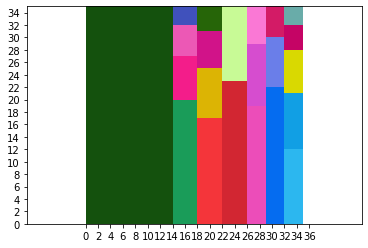

Solution: [[32, 32], [32, 28], [29, 30], [26, 29], [32, 21], [29, 22], [32, 12], [26, 19], [32, 0], [26, 0], [29, 0], [14, 32], [18, 31], [14, 27], [18, 25], [14, 20], [18, 17], [22, 23], [18, 0], [14, 0], [22, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]



|| === Instance 36x36 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=916
mzn-stat: flatIntVars=82
mzn-stat: flatBoolConstraints=234
mzn-stat: flatIntConstraints=956
mzn-stat: evaluatedHalfReifiedConstraints=916
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.262623
mzn-stat-end
mzn-stat: initTime=0.048
mzn-

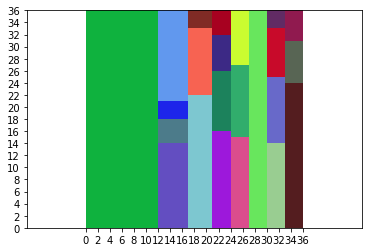

Solution: [[30, 33], [21, 32], [33, 31], [21, 26], [33, 24], [30, 25], [24, 27], [21, 16], [30, 14], [24, 15], [30, 0], [24, 0], [21, 0], [33, 0], [27, 0], [17, 33], [17, 22], [17, 0], [12, 18], [12, 14], [12, 0], [12, 21], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]



|| === Instance 37x37 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1364
mzn-stat: flatIntVars=101
mzn-stat: flatBoolConstraints=346
mzn-stat: flatIntConstraints=1415
mzn-stat: evaluatedHalfReifiedConstraints=1364
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.282438
mzn-s

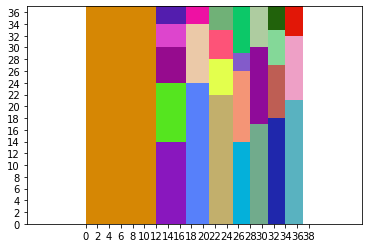

Solution: [[25, 26], [31, 33], [34, 32], [31, 27], [28, 30], [25, 29], [31, 18], [34, 21], [25, 14], [28, 17], [25, 0], [28, 0], [31, 0], [34, 0], [17, 34], [21, 33], [21, 28], [21, 22], [17, 24], [21, 0], [17, 0], [12, 34], [12, 30], [12, 24], [12, 14], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]



|| === Instance 38x38 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=74
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=724
mzn-st

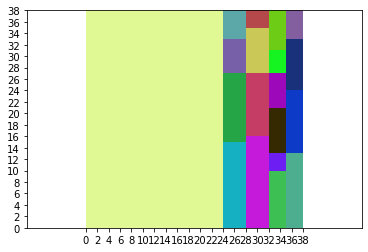

Solution: [[32, 10], [32, 27], [35, 33], [32, 21], [32, 31], [32, 13], [35, 24], [32, 0], [35, 13], [35, 0], [28, 35], [24, 33], [24, 27], [28, 27], [28, 16], [24, 15], [24, 0], [28, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]



|| === Instance 39x39 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1624
mzn-stat: flatIntVars=114
mzn-stat: flatBoolConstraints=406
mzn-stat: flatIntConstraints=1684
mzn-stat: evaluatedHalfReifiedConstraints=1624
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.301787
mzn-stat-end
mzn-stat: initTime=0.075
mzn-stat: solveTime=0.021
mzn-stat: solutions=1
mzn-stat: variables=1747
mzn-s

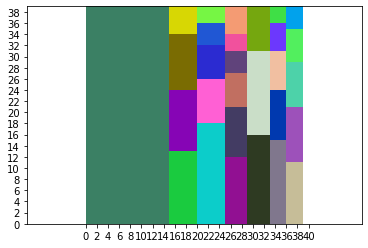

Solution: [[33, 36], [36, 35], [33, 31], [36, 29], [33, 24], [36, 21], [33, 15], [36, 11], [36, 0], [33, 0], [25, 31], [25, 27], [25, 34], [25, 21], [29, 31], [25, 12], [25, 0], [29, 16], [29, 0], [20, 36], [20, 32], [15, 34], [20, 26], [20, 18], [15, 24], [15, 13], [15, 0], [20, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]



|| === Instance 40x40 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=640
mzn-stat: flatIntVars=70
mzn-stat: flatBoolConstr

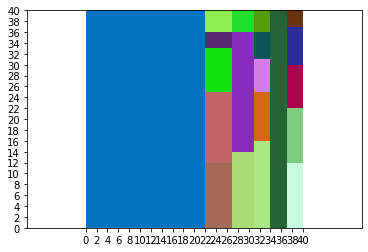

Solution: [[37, 37], [31, 36], [31, 31], [31, 25], [37, 30], [37, 22], [31, 16], [37, 12], [37, 0], [31, 0], [34, 0], [27, 36], [27, 0], [27, 14], [22, 33], [22, 36], [22, 25], [22, 0], [22, 12], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]





In [24]:
"""
Run this part 6 times changing the search_ann (I-min, ff-min, DomWdeg-min, I-rand, ff-rand, DomWdeg-rand) in the model.
"""

starting_instance = 8
ending_instance = 40

for i in range(starting_instance, ending_instance+1):
    path = f"CP/Instances/{i}x{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    
    print(f"|| === Instance {i}x{i} === ||")
    # execute the model to get the first solution in 5 min max
    sol = %minizinc -s CP/$model_name -t 300000
    
    if sol is not None:
        graph_solution(pr_w, pr_h, n_pieces, L, sol['q'])
        #save_solution("CP/out", pr_w, pr_h, n_pieces, L, sol) #-uncomment this line to save the solution of each instance
    else:
        print("No solution found in 5min")
    
    print(f"Pieces: {L}")
    print("\n\n")

ROTATION

%%%mzn-stat: nSolutions=32
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=40
mzn-stat: flatIntVars=34
mzn-stat: flatBoolConstraints=10
mzn-stat: flatIntConstraints=72
mzn-stat: evaluatedHalfReifiedConstraints=40
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.166371
mzn-stat-end
mzn-stat: initTime=0.013
mzn-stat: solveTime=0.004
mzn-stat: solutions=32
mzn-stat: variables=77
mzn-stat: propagators=92
mzn-stat: propagations=14793
mzn-stat: nodes=325
mzn-stat: failures=131
mzn-stat: restarts=0
mzn-stat: peakDepth=18
mzn-stat-end
0 : [[0, 0], [0, 3], [0, 6], [5, 6], [6, 3]] 
rotation: [1, 1, 1, 1, 0]


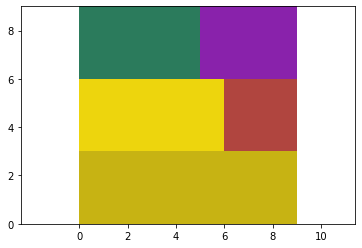

Solution: [[0, 0], [0, 3], [0, 6], [5, 6], [6, 3]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

1 : [[0, 0], [0, 6], [0, 3], [5, 3], [6, 6]] 
rotation: [1, 1, 1, 1, 0]


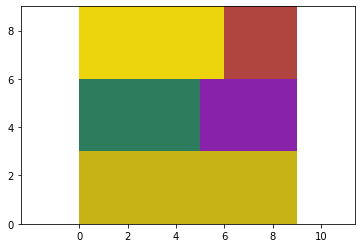

Solution: [[0, 0], [0, 6], [0, 3], [5, 3], [6, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

2 : [[0, 3], [0, 0], [0, 6], [5, 6], [6, 0]] 
rotation: [1, 1, 1, 1, 0]


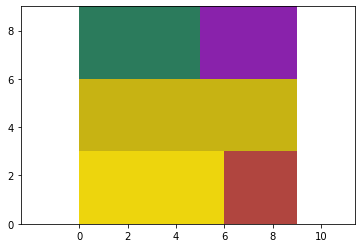

Solution: [[0, 3], [0, 0], [0, 6], [5, 6], [6, 0]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

3 : [[0, 3], [0, 6], [0, 0], [5, 0], [6, 6]] 
rotation: [1, 1, 1, 1, 0]


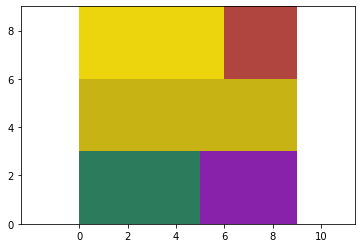

Solution: [[0, 3], [0, 6], [0, 0], [5, 0], [6, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

4 : [[0, 0], [0, 3], [4, 6], [0, 6], [6, 3]] 
rotation: [1, 1, 1, 1, 0]


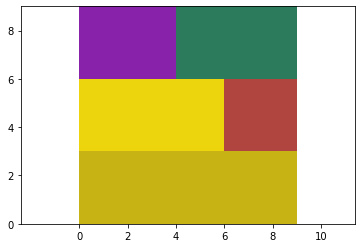

Solution: [[0, 0], [0, 3], [4, 6], [0, 6], [6, 3]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

5 : [[0, 0], [0, 6], [4, 3], [0, 3], [6, 6]] 
rotation: [1, 1, 1, 1, 0]


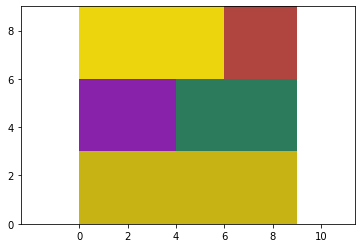

Solution: [[0, 0], [0, 6], [4, 3], [0, 3], [6, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

6 : [[0, 3], [0, 0], [4, 6], [0, 6], [6, 0]] 
rotation: [1, 1, 1, 1, 0]


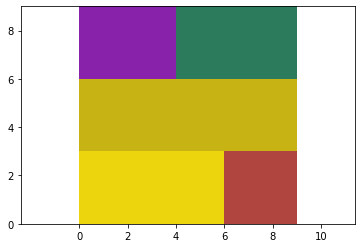

Solution: [[0, 3], [0, 0], [4, 6], [0, 6], [6, 0]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

7 : [[0, 3], [0, 6], [4, 0], [0, 0], [6, 6]] 
rotation: [1, 1, 1, 1, 0]


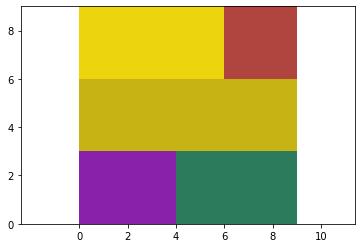

Solution: [[0, 3], [0, 6], [4, 0], [0, 0], [6, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

8 : [[0, 3], [3, 0], [0, 6], [5, 6], [0, 0]] 
rotation: [1, 1, 1, 1, 0]


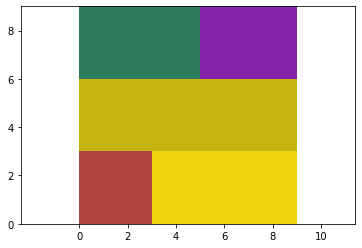

Solution: [[0, 3], [3, 0], [0, 6], [5, 6], [0, 0]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

9 : [[0, 0], [3, 3], [0, 6], [5, 6], [0, 3]] 
rotation: [1, 1, 1, 1, 0]


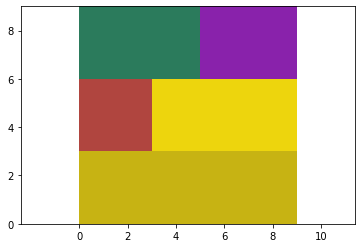

Solution: [[0, 0], [3, 3], [0, 6], [5, 6], [0, 3]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

10 : [[0, 3], [3, 6], [0, 0], [5, 0], [0, 6]] 
rotation: [1, 1, 1, 1, 0]


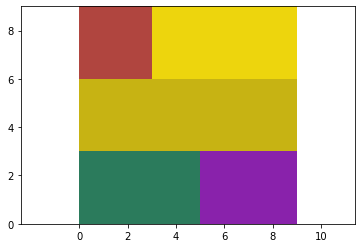

Solution: [[0, 3], [3, 6], [0, 0], [5, 0], [0, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

11 : [[0, 0], [3, 6], [0, 3], [5, 3], [0, 6]] 
rotation: [1, 1, 1, 1, 0]


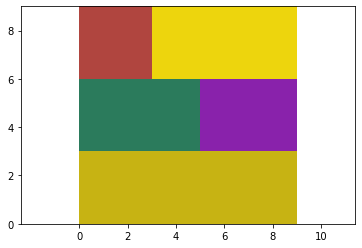

Solution: [[0, 0], [3, 6], [0, 3], [5, 3], [0, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

12 : [[0, 3], [3, 0], [4, 6], [0, 6], [0, 0]] 
rotation: [1, 1, 1, 1, 0]


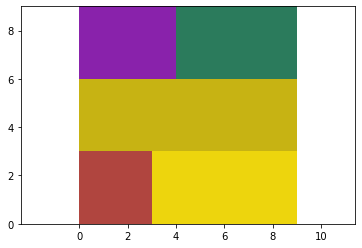

Solution: [[0, 3], [3, 0], [4, 6], [0, 6], [0, 0]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

13 : [[0, 0], [3, 3], [4, 6], [0, 6], [0, 3]] 
rotation: [1, 1, 1, 1, 0]


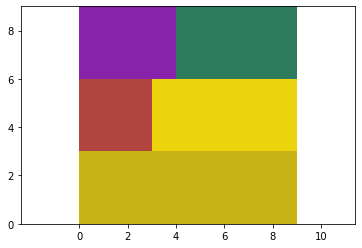

Solution: [[0, 0], [3, 3], [4, 6], [0, 6], [0, 3]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

14 : [[0, 3], [3, 6], [4, 0], [0, 0], [0, 6]] 
rotation: [1, 1, 1, 1, 0]


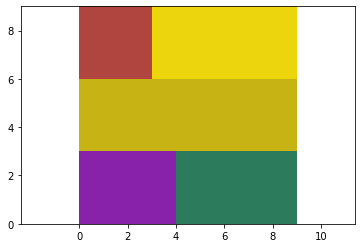

Solution: [[0, 3], [3, 6], [4, 0], [0, 0], [0, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

15 : [[0, 0], [3, 6], [4, 3], [0, 3], [0, 6]] 
rotation: [1, 1, 1, 1, 0]


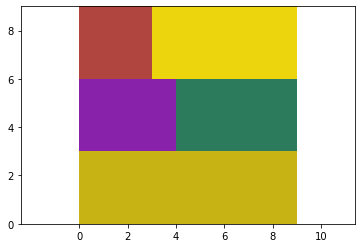

Solution: [[0, 0], [3, 6], [4, 3], [0, 3], [0, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

16 : [[0, 0], [3, 3], [6, 4], [6, 0], [3, 0]] 
rotation: [0, 0, 0, 0, 0]


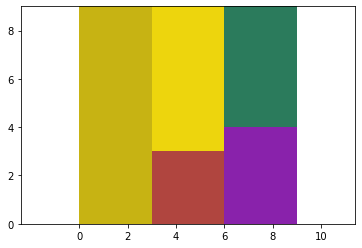

Solution: [[0, 0], [3, 3], [6, 4], [6, 0], [3, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

17 : [[0, 0], [3, 0], [6, 4], [6, 0], [3, 6]] 
rotation: [0, 0, 0, 0, 0]


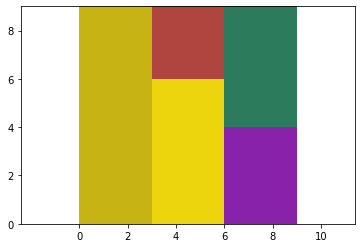

Solution: [[0, 0], [3, 0], [6, 4], [6, 0], [3, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

18 : [[0, 0], [3, 3], [6, 0], [6, 5], [3, 0]] 
rotation: [0, 0, 0, 0, 0]


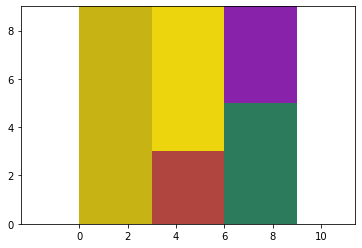

Solution: [[0, 0], [3, 3], [6, 0], [6, 5], [3, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

19 : [[0, 0], [3, 0], [6, 0], [6, 5], [3, 6]] 
rotation: [0, 0, 0, 0, 0]


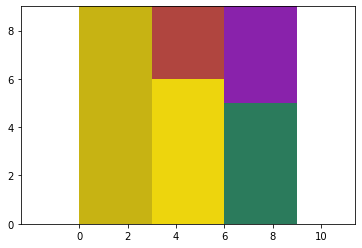

Solution: [[0, 0], [3, 0], [6, 0], [6, 5], [3, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

20 : [[0, 0], [6, 3], [3, 4], [3, 0], [6, 0]] 
rotation: [0, 0, 0, 0, 0]


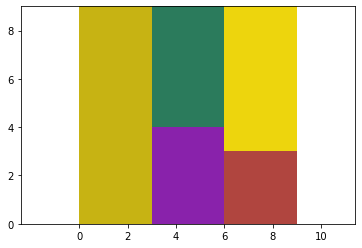

Solution: [[0, 0], [6, 3], [3, 4], [3, 0], [6, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

21 : [[0, 0], [6, 0], [3, 4], [3, 0], [6, 6]] 
rotation: [0, 0, 0, 0, 0]


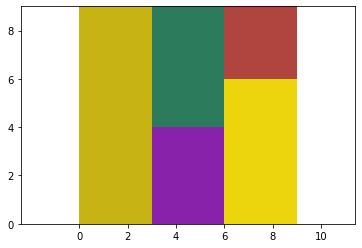

Solution: [[0, 0], [6, 0], [3, 4], [3, 0], [6, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

22 : [[0, 0], [6, 3], [3, 0], [3, 5], [6, 0]] 
rotation: [0, 0, 0, 0, 0]


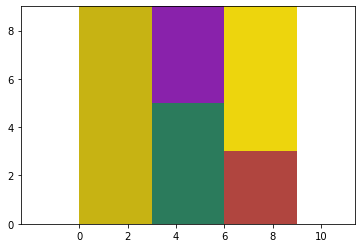

Solution: [[0, 0], [6, 3], [3, 0], [3, 5], [6, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

23 : [[0, 0], [6, 0], [3, 0], [3, 5], [6, 6]] 
rotation: [0, 0, 0, 0, 0]


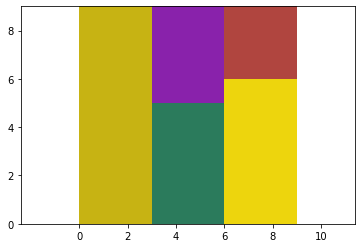

Solution: [[0, 0], [6, 0], [3, 0], [3, 5], [6, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

24 : [[3, 0], [0, 3], [6, 4], [6, 0], [0, 0]] 
rotation: [0, 0, 0, 0, 0]


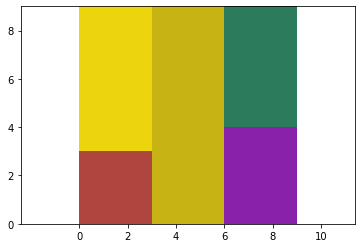

Solution: [[3, 0], [0, 3], [6, 4], [6, 0], [0, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

25 : [[3, 0], [0, 0], [6, 4], [6, 0], [0, 6]] 
rotation: [0, 0, 0, 0, 0]


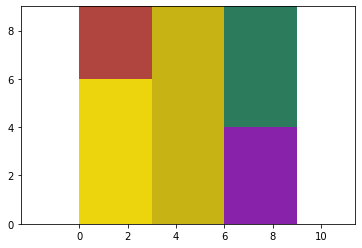

Solution: [[3, 0], [0, 0], [6, 4], [6, 0], [0, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

26 : [[3, 0], [0, 3], [6, 0], [6, 5], [0, 0]] 
rotation: [0, 0, 0, 0, 0]


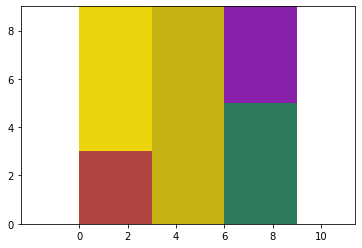

Solution: [[3, 0], [0, 3], [6, 0], [6, 5], [0, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

27 : [[3, 0], [0, 0], [6, 0], [6, 5], [0, 6]] 
rotation: [0, 0, 0, 0, 0]


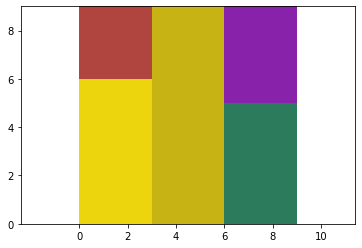

Solution: [[3, 0], [0, 0], [6, 0], [6, 5], [0, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

28 : [[3, 0], [6, 3], [0, 4], [0, 0], [6, 0]] 
rotation: [0, 0, 0, 0, 0]


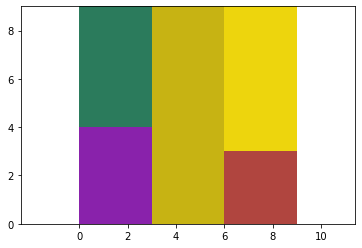

Solution: [[3, 0], [6, 3], [0, 4], [0, 0], [6, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

29 : [[3, 0], [6, 0], [0, 4], [0, 0], [6, 6]] 
rotation: [0, 0, 0, 0, 0]


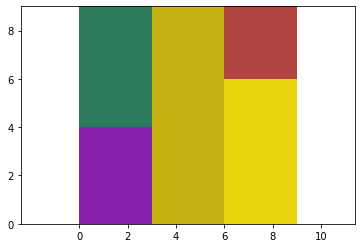

Solution: [[3, 0], [6, 0], [0, 4], [0, 0], [6, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

30 : [[3, 0], [6, 3], [0, 0], [0, 5], [6, 0]] 
rotation: [0, 0, 0, 0, 0]


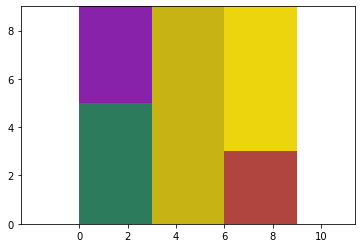

Solution: [[3, 0], [6, 3], [0, 0], [0, 5], [6, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

31 : [[3, 0], [6, 0], [0, 0], [0, 5], [6, 6]] 
rotation: [0, 0, 0, 0, 0]


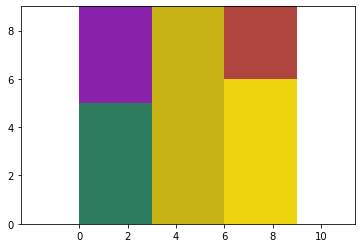

Solution: [[3, 0], [6, 0], [0, 0], [0, 5], [6, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

Tot: 32



In [35]:
model_name = "pwp_v8-rot.mzn"
instance_name = "9x9"

path = f"CP/Instances/{instance_name}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
unordered_pieces = list(L)
decr_order = True

L = order_pieces(unordered_pieces, reverse=decr_order)

solutions = %minizinc -a -s CP/$model_name -t 300000

# Update L for each piece rotated

print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})
#save_solution("CP/out", pr_w, pr_h, n_pieces, L, solutions) #-uncomment this line to save the solution(with rotation)

%%%mzn-stat: nSolutions=26
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=61
mzn-stat: flatIntVars=24
mzn-stat: flatBoolConstraints=16
mzn-stat: flatIntConstraints=77
mzn-stat: evaluatedHalfReifiedConstraints=61
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.158469
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0.001
mzn-stat: solutions=26
mzn-stat: variables=89
mzn-stat: propagators=75
mzn-stat: propagations=3638
mzn-stat: nodes=111
mzn-stat: failures=30
mzn-stat: restarts=0
mzn-stat: peakDepth=6
mzn-stat-end
0 : [[0, 0], [0, 3], [0, 6], [6, 5], [4, 6], [6, 3]] 


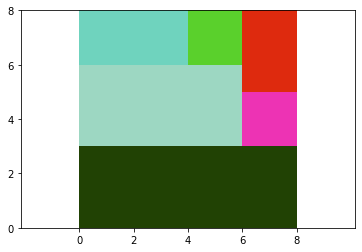

Solution: [[0, 0], [0, 3], [0, 6], [6, 5], [4, 6], [6, 3]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

1 : [[0, 0], [0, 5], [0, 3], [6, 5], [4, 3], [6, 3]] 


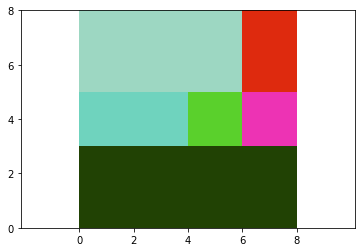

Solution: [[0, 0], [0, 5], [0, 3], [6, 5], [4, 3], [6, 3]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

2 : [[0, 0], [0, 3], [0, 6], [6, 3], [4, 6], [6, 6]] 


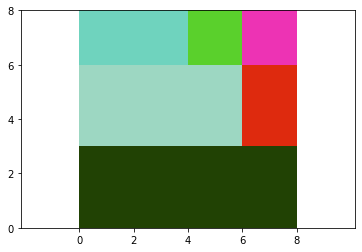

Solution: [[0, 0], [0, 3], [0, 6], [6, 3], [4, 6], [6, 6]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

3 : [[0, 0], [0, 5], [0, 3], [6, 3], [4, 3], [6, 6]] 


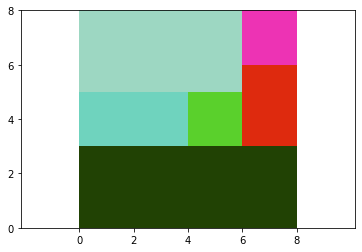

Solution: [[0, 0], [0, 5], [0, 3], [6, 3], [4, 3], [6, 6]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

4 : [[0, 2], [0, 5], [0, 0], [6, 5], [4, 0], [6, 0]] 


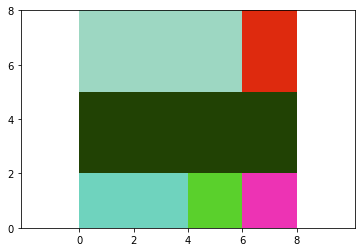

Solution: [[0, 2], [0, 5], [0, 0], [6, 5], [4, 0], [6, 0]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

5 : [[0, 0], [0, 3], [2, 6], [6, 5], [0, 6], [6, 3]] 


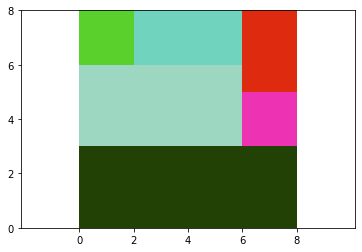

Solution: [[0, 0], [0, 3], [2, 6], [6, 5], [0, 6], [6, 3]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

6 : [[0, 0], [0, 5], [2, 3], [6, 5], [0, 3], [6, 3]] 


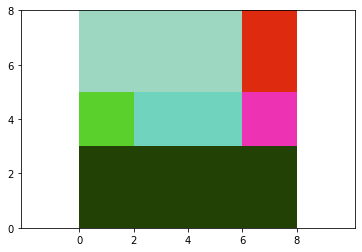

Solution: [[0, 0], [0, 5], [2, 3], [6, 5], [0, 3], [6, 3]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

7 : [[0, 0], [0, 3], [2, 6], [6, 3], [0, 6], [6, 6]] 


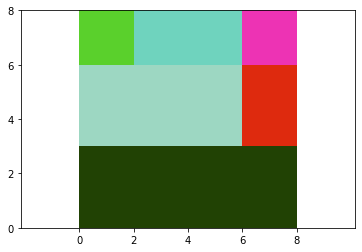

Solution: [[0, 0], [0, 3], [2, 6], [6, 3], [0, 6], [6, 6]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

8 : [[0, 0], [0, 5], [2, 3], [6, 3], [0, 3], [6, 6]] 


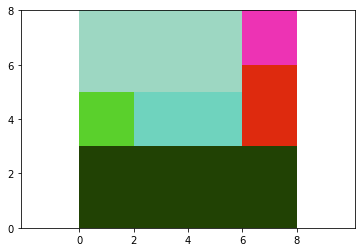

Solution: [[0, 0], [0, 5], [2, 3], [6, 3], [0, 3], [6, 6]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

9 : [[0, 2], [0, 5], [2, 0], [6, 5], [0, 0], [6, 0]] 


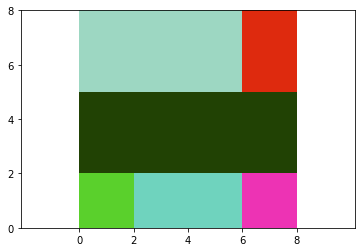

Solution: [[0, 2], [0, 5], [2, 0], [6, 5], [0, 0], [6, 0]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

10 : [[0, 0], [0, 5], [4, 3], [6, 5], [0, 3], [2, 3]] 


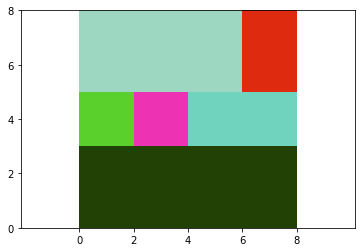

Solution: [[0, 0], [0, 5], [4, 3], [6, 5], [0, 3], [2, 3]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

11 : [[0, 0], [0, 3], [4, 6], [6, 3], [0, 6], [2, 6]] 


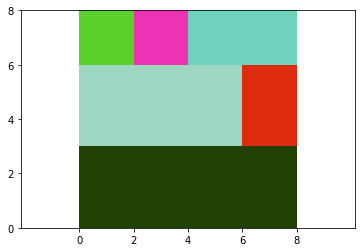

Solution: [[0, 0], [0, 3], [4, 6], [6, 3], [0, 6], [2, 6]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

12 : [[0, 2], [0, 5], [4, 0], [6, 5], [0, 0], [2, 0]] 


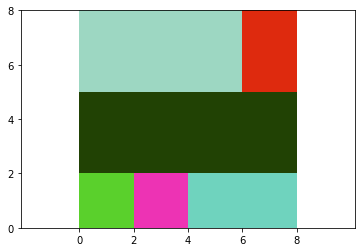

Solution: [[0, 2], [0, 5], [4, 0], [6, 5], [0, 0], [2, 0]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

13 : [[0, 0], [2, 5], [0, 3], [0, 5], [4, 3], [6, 3]] 


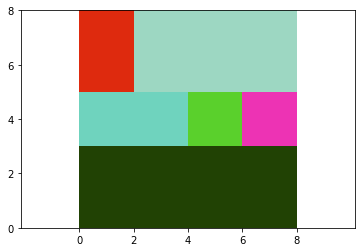

Solution: [[0, 0], [2, 5], [0, 3], [0, 5], [4, 3], [6, 3]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

14 : [[0, 0], [2, 3], [0, 6], [0, 3], [4, 6], [6, 6]] 


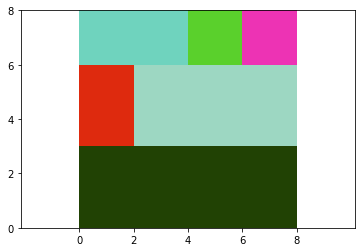

Solution: [[0, 0], [2, 3], [0, 6], [0, 3], [4, 6], [6, 6]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

15 : [[0, 2], [2, 5], [0, 0], [0, 5], [4, 0], [6, 0]] 


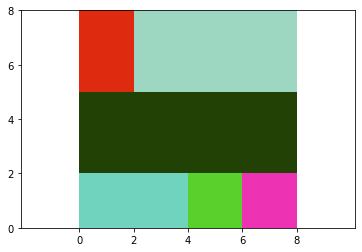

Solution: [[0, 2], [2, 5], [0, 0], [0, 5], [4, 0], [6, 0]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

16 : [[0, 0], [2, 5], [2, 3], [0, 3], [0, 6], [6, 3]] 


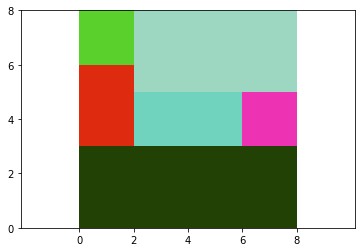

Solution: [[0, 0], [2, 5], [2, 3], [0, 3], [0, 6], [6, 3]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

17 : [[0, 0], [2, 5], [2, 3], [0, 5], [0, 3], [6, 3]] 


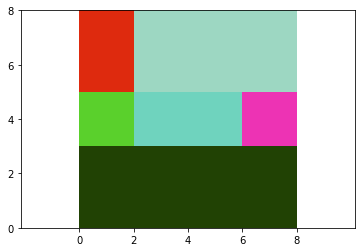

Solution: [[0, 0], [2, 5], [2, 3], [0, 5], [0, 3], [6, 3]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

18 : [[0, 0], [2, 3], [2, 6], [0, 3], [0, 6], [6, 6]] 


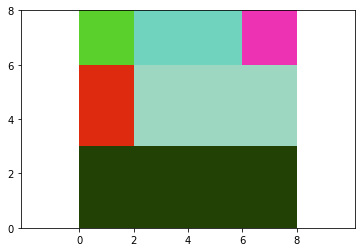

Solution: [[0, 0], [2, 3], [2, 6], [0, 3], [0, 6], [6, 6]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

19 : [[0, 0], [2, 3], [2, 6], [0, 5], [0, 3], [6, 6]] 


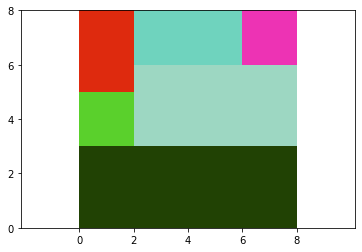

Solution: [[0, 0], [2, 3], [2, 6], [0, 5], [0, 3], [6, 6]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

20 : [[0, 2], [2, 5], [2, 0], [0, 5], [0, 0], [6, 0]] 


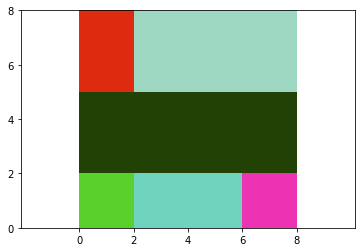

Solution: [[0, 2], [2, 5], [2, 0], [0, 5], [0, 0], [6, 0]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

21 : [[0, 0], [2, 5], [4, 3], [0, 3], [0, 6], [2, 3]] 


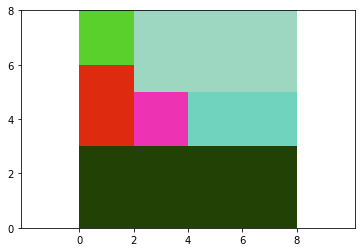

Solution: [[0, 0], [2, 5], [4, 3], [0, 3], [0, 6], [2, 3]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

22 : [[0, 0], [2, 5], [4, 3], [0, 5], [0, 3], [2, 3]] 


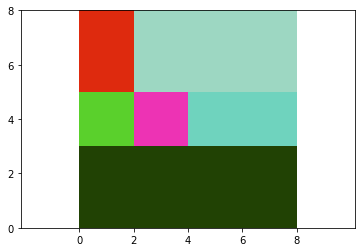

Solution: [[0, 0], [2, 5], [4, 3], [0, 5], [0, 3], [2, 3]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

23 : [[0, 0], [2, 3], [4, 6], [0, 3], [0, 6], [2, 6]] 


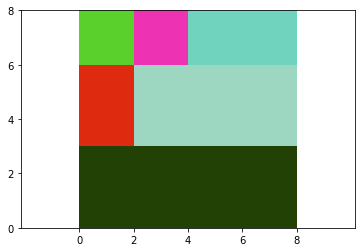

Solution: [[0, 0], [2, 3], [4, 6], [0, 3], [0, 6], [2, 6]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

24 : [[0, 0], [2, 3], [4, 6], [0, 5], [0, 3], [2, 6]] 


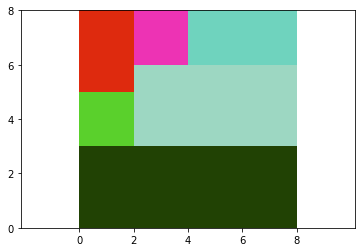

Solution: [[0, 0], [2, 3], [4, 6], [0, 5], [0, 3], [2, 6]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

25 : [[0, 2], [2, 5], [4, 0], [0, 5], [0, 0], [2, 0]] 


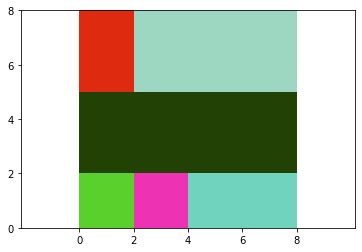

Solution: [[0, 2], [2, 5], [4, 0], [0, 5], [0, 0], [2, 0]]
[w, h]:   [[8, 3], [6, 3], [4, 2], [2, 3], [2, 2], [2, 2]]

Tot: 26



In [44]:
model_name = "pwp_v8-same-dim.mzn"
instance_name = "8x8-same-dim"
"""
Particular instance
8 8
4
3 4
5 2
5 2
8 4
"""
path = f"CP/Instances/{instance_name}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
unordered_pieces = list(L)
decr_order = True

L = order_pieces(unordered_pieces, reverse=decr_order)

solutions = %minizinc -a -s CP/$model_name -t 300000


print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})


%%%mzn-stat: nSolutions=4
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=4
mzn-stat: flatIntVars=13
mzn-stat: flatBoolConstraints=2
mzn-stat: flatIntConstraints=12
mzn-stat: evaluatedHalfReifiedConstraints=4
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.158362
mzn-stat-end
mzn-stat: initTime=0.002
mzn-stat: solveTime=0
mzn-stat: solutions=4
mzn-stat: variables=30
mzn-stat: propagators=12
mzn-stat: propagations=78
mzn-stat: nodes=7
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end
0 : [[0, 3], [5, 3], [0, 0], [5, 0]] 


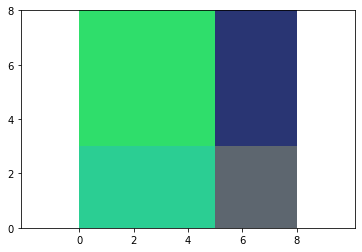

Solution: [[0, 3], [5, 3], [0, 0], [5, 0]]
[w, h]:   [[5, 5], [3, 5], [5, 3], [3, 3]]

1 : [[0, 0], [5, 3], [0, 5], [5, 0]] 


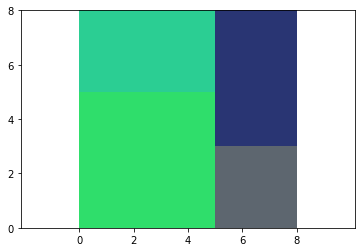

Solution: [[0, 0], [5, 3], [0, 5], [5, 0]]
[w, h]:   [[5, 5], [3, 5], [5, 3], [3, 3]]

2 : [[0, 3], [5, 0], [0, 0], [5, 5]] 


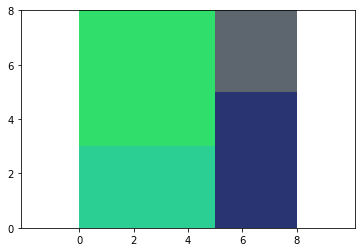

Solution: [[0, 3], [5, 0], [0, 0], [5, 5]]
[w, h]:   [[5, 5], [3, 5], [5, 3], [3, 3]]

3 : [[0, 0], [5, 0], [0, 5], [5, 5]] 


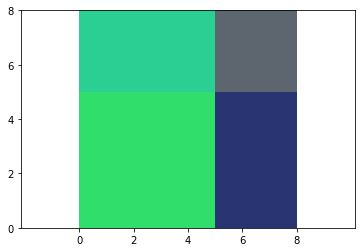

Solution: [[0, 0], [5, 0], [0, 5], [5, 5]]
[w, h]:   [[5, 5], [3, 5], [5, 3], [3, 3]]

Tot: 4

[{'q': [[0, 3], [5, 3], [0, 0], [5, 0]]}, {'q': [[0, 0], [5, 3], [0, 5], [5, 0]]}, {'q': [[0, 3], [5, 0], [0, 0], [5, 5]]}, {'q': [[0, 0], [5, 0], [0, 5], [5, 5]]}]


In [26]:
model_name = "pwp_v8"
instance_name = "8x8"

path = f"CP/Instances/{instance_name}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
unordered_pieces = list(L)
decr_order = True

L = order_pieces(unordered_pieces, reverse=decr_order)

solutions = %minizinc -a -s CP/pwp_v8.mzn -t 300000

# Update L for each piece rotated

print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})
print(solutions)
save_solution("CP/out", pr_w, pr_h, n_pieces, L, solutions)

|| === Instance 8x8 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=4
mzn-stat: flatIntVars=13
mzn-stat: flatBoolConstraints=2
mzn-stat: flatIntConstraints=14
mzn-stat: evaluatedHalfReifiedConstraints=4
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.185039
mzn-stat-end
mzn-stat: initTime=0.019
mzn-stat: solveTime=0.005
mzn-stat: solutions=1
mzn-stat: variables=38
mzn-stat: propagators=12
mzn-stat: propagations=36
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end


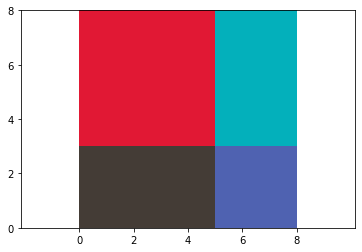

Solution: [[5, 0], [5, 3], [0, 0], [0, 3]]
[w, h]:   [[3, 3], [3, 5], [5, 3], [5, 5]]

Pieces: [[3, 3], [3, 5], [5, 3], [5, 5]]





In [55]:
starting_instance = 8
ending_instance = 8

for i in range(starting_instance, ending_instance+1):
    path = f"CP/Instances/{i}x{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    
    print(f"|| === Instance {i}x{i} === ||")
    # execute the model to get the first solution in 5 min max
    sol = %minizinc -s CP/pwp_v8.mzn -t 300000
    
    if sol is not None:
        graph_solution(pr_w, pr_h, n_pieces, L, sol['q'])
    else:
        print("No solution found in 5min")
        
    print(f"Pieces: {L}")
    print("\n\n")

In [16]:
def create_model(pr_w, pr_h, n_pieces, L):
    q = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n_pieces) ]
    domain = [And(0<=q[i][0],q[i][0]<=pr_w-L[i][0],0<=q[i][1],q[i][1]<= pr_h-L[i][1]) for i in range(n_pieces)]
    
    #--Symmetry breaking rules--
    #  Domain reduction
    areas = [L[i][0]*L[i][1] for i in range(n_pieces)]
    index_largest_p = areas.index(max(areas))
    domain_red = [And(q[index_largest_p][0]<=int((pr_w-L[index_largest_p][0])/2), q[index_largest_p][1]<=int((pr_h-L[index_largest_p][1])/2))]
    
    l_i_j = [Bool("l_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
    u_i_j = [Bool("u_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    #--Large Rectangles--And(Implies(pack, dep))
    large_rec_1 = [And(
            Implies(L[i][0]+L[j][0]>pr_w, And(Not(l_i_j[i*(n_pieces-1)+(j-1)]), Not(l_i_j[i+j*(n_pieces-1)])))
         ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    large_rec_2 = [And(
            Implies(L[i][1]+L[j][1]>pr_h, And(Not(u_i_j[i*(n_pieces-1)+(j-1)]), Not(u_i_j[i+j*(n_pieces-1)])))
         ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    
    l_val = [And(l_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][0]+L[i][0]<=q[j][0])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    u_val = [And(u_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][1]+L[i][1]<=q[j][1])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    e = Int('e')
    f = Int('f')

    e_dom = [And(e>=0, e<=pr_w-L[i][0]) for i in range(n_pieces)]
    f_dom = [And(f>=0, f<=pr_h-L[i][1]) for i in range(n_pieces)]

    Px = [ Bool("px_%s" % (i)) for i in range(n_pieces) ]
    Py = [ Bool("py_%s" % (i)) for i in range(n_pieces) ]


    px_t = [And(Px[i]==(q[i][0]<=e),
               ) for i in range(n_pieces)]
    py_t = [And(Py[i]==(q[i][1]<=f),
               ) for i in range(n_pieces)]

    #;Order Encoding
    o_e_px = [ And(
        Or(
            Not(Px[i]), q[i][0]<=(e+1)
         )) for i in range(n_pieces)]
    o_e_py = [ And(
        Or(
            Not(Py[i]), q[i][1]<=(f+1)
         )) for i in range(n_pieces)]

    #;Non-Overlapping 1
    n_o_1 = [ And(
        Or(
            l_i_j[i*(n_pieces-1)+(j-1)], l_i_j[i+j*(n_pieces-1)], u_i_j[i*(n_pieces-1)+(j-1)], u_i_j[i+j*(n_pieces-1)]
         )) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

    #;Non-Overlapping 2
    n_o_2_1 = [ And(
            Or(Not(l_i_j[i*(n_pieces-1)+(j-1)]), Px[i], Not(q[j][0]<=(e+L[i][0])))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

    n_o_2_2 = [ And(
            Or(Not(l_i_j[j*(n_pieces-1)+i]), Px[j], Not(q[j][0]<=(e+L[j][0])))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces)]

    n_o_2_3 = [ And(
            Or(Not(u_i_j[i*(n_pieces-1)+(j-1)]), Py[i], Not(q[j][1]<=(f+L[i][1])))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

    n_o_2_4 = [ And(
            Or(Not(u_i_j[j*(n_pieces-1)+i]), Py[j], Not(q[i][1]<=(f+L[j][1])))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    
    return q, domain + domain_red + large_rec_1 + large_rec_2 + l_val + u_val + e_dom + f_dom + px_t + py_t + o_e_px + o_e_py + n_o_1 + n_o_2_1 + n_o_2_2 + n_o_2_3 + n_o_2_4

In [100]:
def create_model2(pr_w, pr_h, n_pieces, L):
    q = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n_pieces) ]
    domain = [And(0<=q[i][0],q[i][0]<pr_w,0<=q[i][1],q[i][1]< pr_h) for i in range(n_pieces)]
    in_strip = [And(pr_w>=q[i][0]+L[i][0],pr_h>=q[i][1]+L[i][1]) for i in range(n_pieces)]
    l_i_j = [Bool("l_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
    u_i_j = [Bool("u_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    l_prova = [And(l_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][0]+L[i][0]<=q[j][0])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    u_prova = [And(u_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][1]+L[i][1]<=q[j][1])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    e = Int('e')
    f = Int('f')
    
    max_e = max([pr_w-L[i][0] for i in range(n_pieces)])
    max_f = max([pr_h-L[i][1] for i in range(n_pieces)])

    e_dom = [And(e>=0, e<=pr_w-L[i][0]) for i in range(n_pieces)]
    f_dom = [And(f>=0, f<=pr_h-L[i][1]) for i in range(n_pieces)]

    px = [ Bool("px_%s_%s" % (i, j)) for j in range(max_e) for i in range(n_pieces) ]
    py = [ Bool("py_%s_%s" % (i, j)) for j in range(max_f) for i in range(n_pieces) ]

    px_t = [And(px[(j*(n_pieces)+i)]==(q[i][0]<=j),
               ) for i in range(n_pieces) for j in range(max_e)]
    py_t = [And(py[(j*(n_pieces)+i)]==(q[i][1]<=j),
               ) for j in range(max_f) for i in range(n_pieces)]

    #;Order Encoding
    o_e_px = [ And(
        Or(
            Not(px[(j*(n_pieces)+i)]), px[((j+1)*(n_pieces)+i)]
         )) for i in range(n_pieces) for j in range(max_e-1) ]
    o_e_py = [ And(
        Or(
            Not(py[(j*(n_pieces)+i)]), py[((j+1)*(n_pieces)+i)]
         )) for i in range(n_pieces) for j in range(max_f-1) ]

    index = ["%s-%s"%(i, j) for i in range(n_pieces) for j in range(i+1,n_pieces)] 

    #;Non-Overlapping 1
    n_o_1 = [ And(
        Or(
            l_i_j[i*(n_pieces-1)+(j-1)], l_i_j[i+j*(n_pieces-1)], u_i_j[i*(n_pieces-1)+(j-1)], u_i_j[i+j*(n_pieces-1)]
         )) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

    #;Non-Overlapping 2
    n_o_2_1 = [ And(
            Or(Not(l_i_j[i*(n_pieces-1)+(j-1)]), px[(e*(n_pieces)+i)], Not(px[((e+L[i][0])*(n_pieces)+j)]))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces) for e in range(max_e-L[i][0]) ]

    n_o_2_2 = [ And(
            Or(Not(l_i_j[j*(n_pieces-1)+i]), px[(e*(n_pieces)+j)], Not(px[((e+L[j][0])*(n_pieces)+i)]))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces) for e in range(max_e-L[j][0]) ]

    n_o_2_3 = [ And(
            Or(Not(u_i_j[i*(n_pieces-1)+(j-1)]), py[(f*(n_pieces)+i)], Not(py[((f+L[i][1])*(n_pieces)+j)]))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces) for f in range(max_f-L[i][1]) ]

    n_o_2_4 = [ And(
            Or(Not(u_i_j[j*(n_pieces-1)+i]), py[(f*(n_pieces)+j)], Not(py[((f+L[j][1])*(n_pieces)+i)]))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces) for f in range(max_f-L[j][1]) ]
    
    return q, domain + in_strip + l_prova + u_prova + e_dom + f_dom + px_t + py_t + o_e_px + o_e_py + n_o_1 #+ n_o_2_1 + n_o_2_2 + n_o_2_3 + n_o_2_4

|| === Instance 22x22 === ||
{0.980} secs
coords:   [[3, 4], [10, 18], [6, 19], [3, 17], [0, 4], [10, 0], [19, 14], [0, 0], [13, 13], [3, 7], [10, 7], [0, 10], [13, 0], [19, 0], [16, 0], [6, 0]]


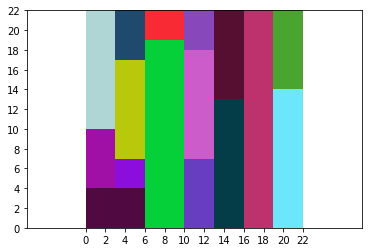

Solution: [[3, 4], [10, 18], [6, 19], [3, 17], [0, 4], [10, 0], [19, 14], [0, 0], [13, 13], [3, 7], [10, 7], [0, 10], [13, 0], [19, 0], [16, 0], [6, 0]]
[w, h]:   [[3, 3], [3, 4], [4, 3], [3, 5], [3, 6], [3, 7], [3, 8], [6, 4], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 19]]

Tot: 1

Pieces: [[3, 3], [3, 4], [4, 3], [3, 5], [3, 6], [3, 7], [3, 8], [6, 4], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 19]]



Wall time: 1.57 s


In [20]:
%%time
import time

starting_instance = 22
ending_instance = 22

for i in range(starting_instance, ending_instance+1):
    
    path = f"CP/Instances/{i}x{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    
    print(f"|| === Instance {i}x{i} === ||")
    unordered_pieces = list(L)
    
    decr_order = False
    L = order_pieces(unordered_pieces, reverse=decr_order)
    model = create_model(pr_w, pr_h, n_pieces, L) #0: variables, 1:constraints
    q = model[0]
    s = Solver()
    
    s.add(model[1])
    #s.set("timeout", 600)
    
    start = time.time()
    res = s.check()
    end = time.time()
    print("{%.3f} secs" % (end - start))

    if res == z3.unsat:
        print("Unsat")
        continue
    
    sol = s.model()
    #print(s.statistics())
    solution=[[sol[q[p][0]].as_long(), sol[q[p][1]].as_long()] for p in range(n_pieces)]
    
    prova = {'q': solution}
    print_solutions(prova, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})
        
    print(f"Pieces: {L}")
    print("\n\n")




In [312]:
q = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n_pieces) ]
domain = [And(0<=q[i][0],q[i][0]<pr_w,0<=q[i][1],q[i][1]< pr_h) for i in range(n_pieces)]
in_strip = [And(pr_w>=q[i][0]+L[i][0],pr_h>=q[i][1]+L[i][1]) for i in range(n_pieces)]
l_i_j = [Bool("l_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
u_i_j = [Bool("u_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

"""
l = [And(l_i_j[0]==(q[0][0]+L[0][0]<=q[1][0]), l_i_j[1]==(q[0][0]+L[0][0]<=q[2][0]), l_i_j[2]==(q[0][0]+L[0][0]<=q[3][0]),
         l_i_j[3]==(q[1][0]+L[1][0]<=q[0][0]), l_i_j[4]==(q[1][0]+L[1][0]<=q[2][0]), l_i_j[5]==(q[1][0]+L[1][0]<=q[3][0]),
         l_i_j[6]==(q[2][0]+L[2][0]<=q[0][0]), l_i_j[7]==(q[2][0]+L[2][0]<=q[1][0]), l_i_j[8]==(q[2][0]+L[2][0]<=q[3][0]),
         l_i_j[9]==(q[3][0]+L[3][0]<=q[0][0]), l_i_j[10]==(q[3][0]+L[3][0]<=q[1][0]), l_i_j[11]==(q[3][0]+L[3][0]<=q[2][0])
        )]
"""
l_prova = [And(l_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][0]+L[i][0]<=q[j][0])
            
            ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

"""
u = [And(u_i_j[0]==(q[0][1]+L[0][1]<=q[1][1]), u_i_j[1]==(q[0][1]+L[0][1]<=q[2][1]), u_i_j[2]==(q[0][1]+L[0][1]<=q[3][1]),
         u_i_j[3]==(q[1][1]+L[1][1]<=q[0][1]), u_i_j[4]==(q[1][1]+L[1][1]<=q[2][1]), u_i_j[5]==(q[1][1]+L[1][1]<=q[3][1]),
         u_i_j[6]==(q[2][1]+L[2][1]<=q[0][1]), u_i_j[7]==(q[2][1]+L[2][1]<=q[1][1]), u_i_j[8]==(q[2][1]+L[2][1]<=q[3][1]),
         u_i_j[9]==(q[3][1]+L[3][1]<=q[0][1]), u_i_j[10]==(q[3][1]+L[3][1]<=q[1][1]), u_i_j[11]==(q[3][1]+L[3][1]<=q[2][1])
        )]
"""
u_prova = [And(u_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][1]+L[i][1]<=q[j][1])
            
            ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

e = Int('e')
f = Int('f')

max_e = max([pr_w-L[i][0] for i in range(n_pieces)])
max_f = max([pr_h-L[i][1] for i in range(n_pieces)])

e_dom = [And(e>=0, e<=pr_w-L[i][0]) for i in range(n_pieces)]
f_dom = [And(f>=0, f<=pr_h-L[i][1]) for i in range(n_pieces)]


px = [ Bool("px_%s_%s" % (i, j)) for j in range(max_e) for i in range(n_pieces) ]
py = [ Bool("py_%s_%s" % (i, j)) for j in range(max_f) for i in range(n_pieces) ]

px_t = [And(px[(j*(n_pieces)+i)]==(q[i][0]<=j),
        ) for i in range(n_pieces) for j in range(max_e)]
py_t = [And(py[(j*(n_pieces)+i)]==(q[i][1]<=j),
        ) for j in range(max_f) for i in range(n_pieces)]

#;Order Encoding

o_e_px = [ And(
    Or(
        Not(px[(j*(n_pieces)+i)]), px[((j+1)*(n_pieces)+i)]
     )) for i in range(n_pieces) for j in range(max_e-1) ]
o_e_py = [ And(
    Or(
        Not(py[(j*(n_pieces)+i)]), py[((j+1)*(n_pieces)+i)]
     )) for i in range(n_pieces) for j in range(max_f-1) ]
#A = Array('A', IntSort(), IntSort())
#type(A[e])
index = ["%s-%s"%(i, j) for i in range(n_pieces) for j in range(i+1,n_pieces)] 
#['0-1', '0-2', '0-3', '1-2', '1-3', '2-3']
#['0',   '1',   '2',   '4',   '5',   '8']  i*3+(j-1)
#['3',   '6',   '9',   '7',   '10',   '11'] i+j*3

#;Non-Overlapping 1
n_o_1 = [ And(
    Or(
        l_i_j[i*(n_pieces-1)+(j-1)], l_i_j[i+j*(n_pieces-1)], u_i_j[i*(n_pieces-1)+(j-1)], u_i_j[i+j*(n_pieces-1)]
     )) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

#;Non-Overlapping 2
n_o_2_1 = [ And(
        Or(Not(l_i_j[i*(n_pieces-1)+(j-1)]), px[(e*(n_pieces)+i)], Not(px[((e+L[i][0])*(n_pieces)+j)]))
            ) for i in range(n_pieces) for j in range(i+1,n_pieces) for e in range(max_e-L[i][0]) ]

n_o_2_2 = [ And(
        Or(Not(l_i_j[j*(n_pieces-1)+i]), px[(e*(n_pieces)+j)], Not(px[((e+L[j][0])*(n_pieces)+i)]))
            ) for i in range(n_pieces) for j in range(i+1,n_pieces) for e in range(max_e-L[j][0]) ]

n_o_2_3 = [ And(
        Or(Not(u_i_j[i*(n_pieces-1)+(j-1)]), py[(f*(n_pieces)+i)], Not(py[((f+L[i][1])*(n_pieces)+j)]))
            ) for i in range(n_pieces) for j in range(i+1,n_pieces) for f in range(max_f-L[i][1]) ]

n_o_2_4 = [ And(
        Or(Not(u_i_j[j*(n_pieces-1)+i]), py[(f*(n_pieces)+j)], Not(py[((f+L[j][1])*(n_pieces)+i)]))
            ) for i in range(n_pieces) for j in range(i+1,n_pieces) for f in range(max_f-L[j][1]) ]
        

coords:   [[3, 8], [3, 0], [0, 0], [0, 5], [6, 8], [6, 0], [3, 4]]


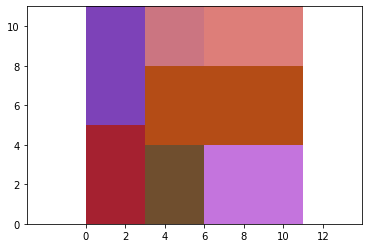

Solution: [[3, 8], [3, 0], [0, 0], [0, 5], [6, 8], [6, 0], [3, 4]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

Tot: 1

Wall time: 145 ms


In [313]:
%%time
s = Solver()
s.add(domain + in_strip + l_prova + u_prova + e_dom + f_dom + px_t + py_t + o_e_px + o_e_py + n_o_1 + n_o_2_1 + n_o_2_2 + n_o_2_3 + n_o_2_4) #overflow + intersection)
s.check()
sol = s.model()
solution=[[sol[q[i][0]].as_long(), sol[q[i][1]].as_long()] for i in range(n_pieces)]


prova = {'q': solution}
print_solutions(prova, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

In [60]:
instance = "8x8"
path = f"CP/Instances/{instance}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)

unordered_pieces = list(L)
decr_order = True

#L = order_pieces(unordered_pieces, reverse=decr_order)
pr_w, pr_h, n_pieces, L

(8, 8, 4, [[3, 3], [3, 5], [5, 3], [5, 5]])